In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import sys

In [16]:
path = 'data/cold/Youshu'
ui = pd.read_csv(os.path.join(path, 'user_item.txt'), sep='\t', header=None)
bi = pd.read_csv(os.path.join(path, 'bundle_item.txt'), sep='\t', header=None)
ui.columns = ['user', 'item']
bi.columns = ['bundle', 'item']

ub_train = pd.read_csv(os.path.join(path, 'user_bundle_train.txt'), sep='\t', header=None)
ub_tune = pd.read_csv(os.path.join(path, 'user_bundle_tune.txt'), sep='\t', header=None)
ub_test = pd.read_csv(os.path.join(path, 'user_bundle_test.txt'), sep='\t', header=None)
ub = pd.concat([ub_train, ub_tune, ub_test], ignore_index=True)
ub.columns = ['user', 'bundle']

Visualize UI

<Axes: ylabel='Frequency'>

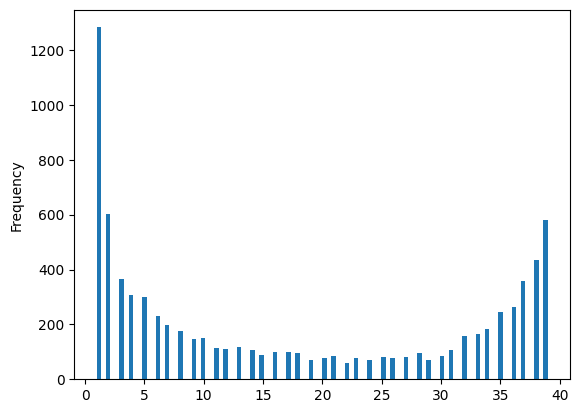

In [14]:
ui['user'].value_counts().plot(kind='hist', bins=100)

Visualize IU

<Axes: ylabel='Frequency'>

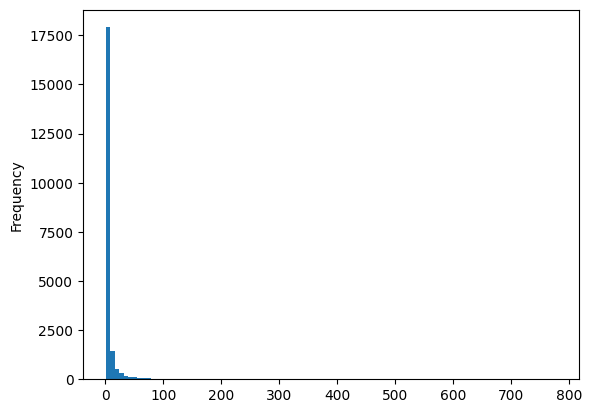

In [18]:
ui['item'].value_counts().plot(kind='hist', bins=100)

Visualize BI

<Axes: ylabel='Frequency'>

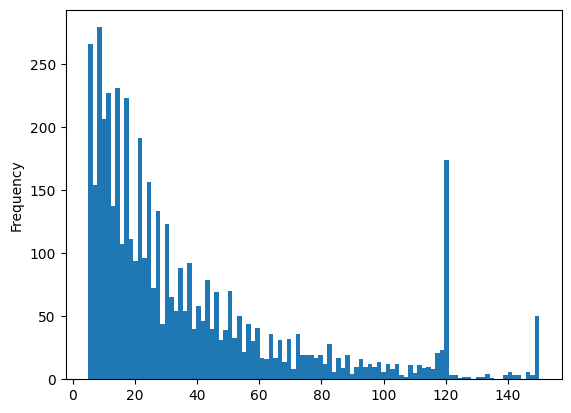

In [15]:
bi['bundle'].value_counts().plot(kind='hist', bins=100)

Visualize IB

<Axes: ylabel='Frequency'>

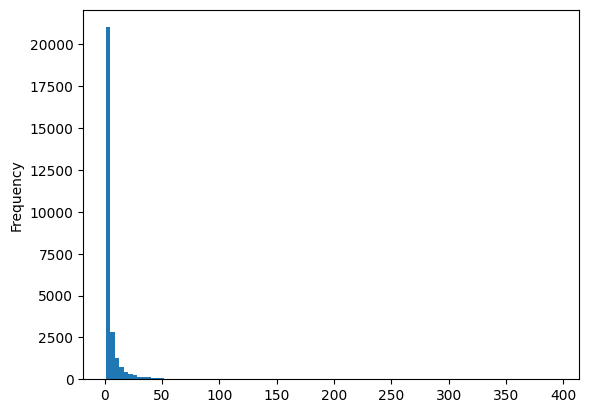

In [19]:
bi['item'].value_counts().plot(kind='hist', bins=100)

Visualize UB

<Axes: ylabel='Frequency'>

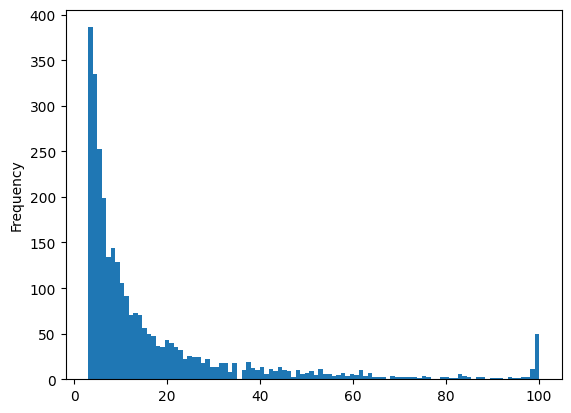

In [17]:
ub['user'].value_counts().plot(kind='hist', bins=100)

Visualize BU

<Axes: ylabel='Frequency'>

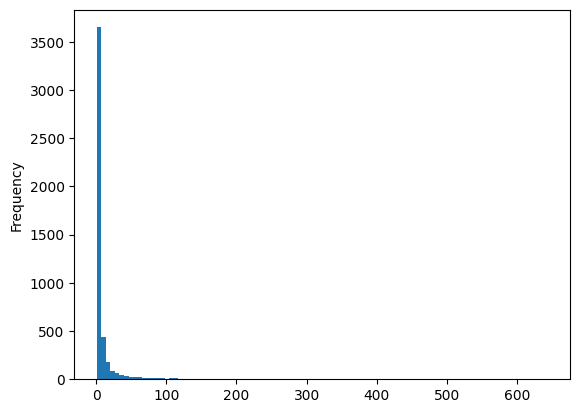

In [20]:
ub['bundle'].value_counts().plot(kind='hist', bins=100)